In this notebook, we're going to construct a word2vec model CBOW-style. We'll also install [Gensim](https://radimrehurek.com/gensim/) and see how that package can be used to train word vectors.

In [ ]:
!pip install -q --upgrade gensim

     |████████████████████████████████| 24.2MB 125kB/s 


In [ ]:
!pip install -q --upgrade smart_open

In [ ]:
%tensorflow_version 2.x

import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import gensim
import re

We'll also download the "Alice in Wonderland" book as a data set to work with from Project Gutenberg.

In [ ]:
!wget http://www.gutenberg.org/files/11/11-0.txt -O alice.txt

--2020-07-21 13:30:22--  http://www.gutenberg.org/files/11/11-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174484 (170K) [text/plain]
Saving to: ‘alice.txt’

alice.txt           100%[===================>] 170.39K   168KB/s    in 1.0s    

2020-07-21 13:30:24 (168 KB/s) - ‘alice.txt’ saved [174484/174484]



Next, we're going to read in the text file. We'll clean this up a bit so we only keep alphanumerical characters, spaces and periods. We'll also convert everything to lowercase.

In [ ]:
path = 'alice.txt'
corpus = open(path).readlines()
corpus = (' '.join([re.sub('[^a-zA-Z0-9\. ]+', '', sentence).lower() for sentence in corpus])).split('.')

corpus[30:40]

[' i wonder if i shall fall right through the earth how funny itll seem to come out among the people that walk with their heads downward the antipathies i think she was rather glad there was no one listening this time as it didnt sound at all the right word but i shall have to ask them what the name of the country is you know',
 ' please maam is this new zealand or australia and she tried to curtsey as she spokefancy curtseying as youre falling through the air do you think you could manage it and what an ignorant little girl shell think me for asking no itll never do to ask perhaps i shall see it written up somewhere',
 '  down down down',
 ' there was nothing else to do so alice soon began talking again',
 ' dinahll miss me very much tonight i should think dinah was the cat',
 ' i hope theyll remember her saucer of milk at teatime',
 ' dinah my dear i wish you were down here with me there are no mice in the air im afraid but you might catch a bat and thats very like a mouse you know',

We're now ready to start modeling. We'll make use of the [Keras Tokenizer](https://keras.io/preprocessing/text/) here to convert our text to an indexed corpus.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

corpus_indexed = tokenizer.texts_to_sequences(corpus)
num_samples    = sum(len(s) for s in corpus_indexed)
V              = len(tokenizer.word_index) + 1 # As 0 is a reserved index and not included

print('Vocabulary size   =', V)
print('Number of samples =', num_samples)

print('First sentence (indexed)        =', corpus_indexed[0])
print('First sentence (converted back) =', tokenizer.sequences_to_texts([corpus_indexed[0]]))

Vocabulary size   = 3246
Number of samples = 29638
First sentence (indexed)        = [1, 46, 119, 351, 5, 227, 352, 9, 457, 50, 773, 774, 21, 351, 33, 22, 1, 158, 5, 655, 947, 18, 42, 775, 2, 17, 458, 42, 1221, 1222]
First sentence (converted back) = ['the project gutenberg ebook of alices adventures in wonderland by lewis carroll this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever']


We will now create a helper function to generate instances from the corpus. For each sentence in the corpus, and each word in that sentence, we extract the word as the context word and the words around it as the context. We then pad the sequences and convert the context words to one-hot categoricals:

In [ ]:
def generate_data(corpus_indexed, window_size, V):
  maxlen = window_size * 2
  for sentence in corpus_indexed:
    L = len(sentence)
    for index, word in enumerate(sentence):
      contexts = []
      labels   = []            
      s = index - window_size
      e = index + window_size + 1
      contexts.append([sentence[i] for i in range(s, e) if 0 <= i < L and i != index])
      labels.append(word)
      x = sequence.pad_sequences(contexts, maxlen=maxlen)
      y = to_categorical(labels, V)
      yield (x, y)

An example can help to show how this works:

In [ ]:
for x, y in generate_data(corpus_indexed, 2, V):
  print(x.shape, x) # context indexes
  print(y.shape, y) # target word
  break

(1, 4) [[  0   0  46 119]]
(1, 3246) [[0. 1. 0. ... 0. 0. 0.]]


We're now ready to define our network given a dimensionality for the embedding and the window size we want.

In [ ]:
dim         = 64
window_size = 4

cbow = Sequential()
cbow.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow.add(Dense(V, activation='softmax'))

cbow.summary()

cbow.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 64)             207744    
_________________________________________________________________
lambda (Lambda)              (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3246)              210990    
Total params: 418,734
Trainable params: 418,734
Non-trainable params: 0
_________________________________________________________________


Let's now generate all possible instances we can use to train:

In [ ]:
X, y = [], []
for x_, y_ in generate_data(corpus_indexed, window_size, V):
    X.append(x_)
    y.append(y_)

X = np.array(X).squeeze(axis=1)
y = np.array(y).squeeze(axis=1)

X.shape, y.shape

((29638, 8), (29638, 3246))

And let's now train...

In [ ]:
batch_size = 128
epochs     = 200

hist = cbow.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=0)

Let's plot our loss and accuracy to see how things went. This example also illustrates how you can use the output of the `fit` method:

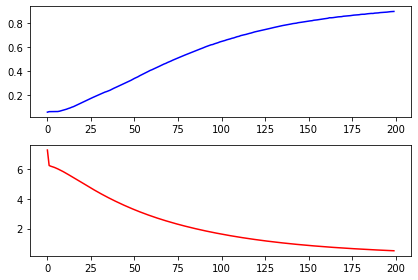

In [ ]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(hist.history['accuracy'], c='b')
ax[1].plot(hist.history['loss'], c='r')
plt.tight_layout()

This looks good, we can now get the embedding for a word straight from the weights:

In [ ]:
vectors = cbow.get_weights()[0]

print('Embedding layer shape =', vectors.shape)

vectors[tokenizer.word_index['alice'], :]

Embedding layer shape = (3246, 64)


array([ 0.33831316,  1.0022782 ,  0.33131233, -1.2422192 ,  0.2984038 ,
       -0.88905865,  1.7507093 , -0.11863818, -1.121816  ,  0.4908823 ,
       -1.1836679 , -0.68746394, -0.27583766,  0.32752797, -3.5322545 ,
       -0.92833424, -2.2141342 , -0.7156451 , -1.2652615 ,  1.501692  ,
        1.7566893 ,  1.631279  ,  2.0088594 , -0.66838056, -0.25244847,
        2.3890529 ,  0.9713185 ,  2.7787828 ,  1.4630933 , -1.4826314 ,
       -0.33832002,  1.3235847 ,  0.7077462 , -0.76816565,  1.3136119 ,
       -2.6728494 ,  1.6672424 ,  0.30327183,  0.07138109,  0.26950926,
       -1.2320868 , -1.3589747 , -1.8185089 ,  0.6420739 ,  2.7487097 ,
        0.76063746, -0.23964696,  0.59171313, -2.9159918 ,  0.10143914,
        0.0763538 ,  2.0258133 , -1.3893231 , -0.0606821 ,  3.4017572 ,
       -1.299965  ,  0.30173108, -0.28952834, -2.3312347 ,  1.5302079 ,
        0.5650899 ,  0.7768151 ,  0.39259335, -2.1290154 ], dtype=float32)

We could also try to visualize the weight like follows, e.g. for the first 100 words:

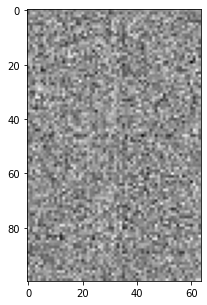

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(vectors[:100, :], cmap='gray')

More interestingly however, we can perform distance operations in the embedding space. To do so, we are going to use `gensim` to read in our trained word vectors. Gensim can also train the embeddings by itself, which we'll show later on.

In [ ]:
# Save our vectors in the word2vec format (which is a simple space delimited format)

f = open('vectors.txt' ,'w')

# The first line contains the vocabulary size (we won't include the zero index)
f.write('{} {}\n'.format(V-1, dim))

# The next lines contain the word and the embedding
for word, i in tokenizer.word_index.items():
  str_vec = ' '.join(map(str, list(vectors[i, :])))
  f.write('{} {}\n'.format(word, str_vec))

f.close()

In [ ]:
# Read in the word vectors
w2v = gensim.models.KeyedVectors.load_word2vec_format('vectors.txt', binary=False)

We can now ask this object some queries. Such as: which words look most similar to "dark"?

In [ ]:
w2v.most_similar(positive=['dark'])

[('belong', 0.4830104410648346),
 ('happen', 0.4604029059410095),
 ('seehow', 0.458426296710968),
 ('slates', 0.4537699818611145),
 ('overcome', 0.44486820697784424),
 ('crept', 0.4427439570426941),
 ('become', 0.4394567310810089),
 ('educationsin', 0.4393708407878876),
 ('justice', 0.4378603398799896),
 ('hunting', 0.43579399585723877)]

Most dissimilar to "happy"?

In [ ]:
w2v.most_similar(negative=['happy'])

[('enormous', 0.4389593005180359),
 ('snorting', 0.43480542302131653),
 ('flown', 0.3966081440448761),
 ('theres', 0.38897091150283813),
 ('outoftheway', 0.383871853351593),
 ('royalty', 0.3724365532398224),
 ('dark', 0.36264872550964355),
 ('gardenhow', 0.3578796982765198),
 ('dinahll', 0.3527597486972809),
 ('dressed', 0.34911593794822693)]

What is to "alice" as "dark" is to "bright"?

In [ ]:
w2v.most_similar(positive=['alice', 'dark'], negative=['bright'])

[('goodnatured', 0.5226839780807495),
 ('pleasanter', 0.4880197048187256),
 ('choose', 0.47827237844467163),
 ('stopping', 0.4641485810279846),
 ('become', 0.447035551071167),
 ('belong', 0.4467378258705139),
 ('practice', 0.4407171308994293),
 ('seehow', 0.4240052103996277),
 ('uglify', 0.41998767852783203),
 ('want', 0.4198063910007477)]

We can also ask Gensim to construct word vectors for us:

In [ ]:
model = gensim.models.Word2Vec(sentences=[s.split(' ') for s in tokenizer.sequences_to_texts(corpus_indexed)], size=64, window=4, min_count=0)

In [ ]:
model.wv.most_similar(positive=['dark'])

[('cushion', 0.977382242679596),
 ('mission', 0.976033627986908),
 ('pool', 0.9745422005653381),
 ('seven', 0.9741623997688293),
 ('salt', 0.9740279316902161),
 ('garden', 0.9736586213111877),
 ('near', 0.9732871055603027),
 ('fetch', 0.9732269048690796),
 ('neck', 0.9731500744819641),
 ('children', 0.9729947447776794)]

Let us now perform a t-SNE dimensionality reduction to visualize the embedding space:

In [ ]:
tsne        = TSNE(n_components=2, perplexity=2)
transformed = tsne.fit_transform(model.trainables.syn1neg)

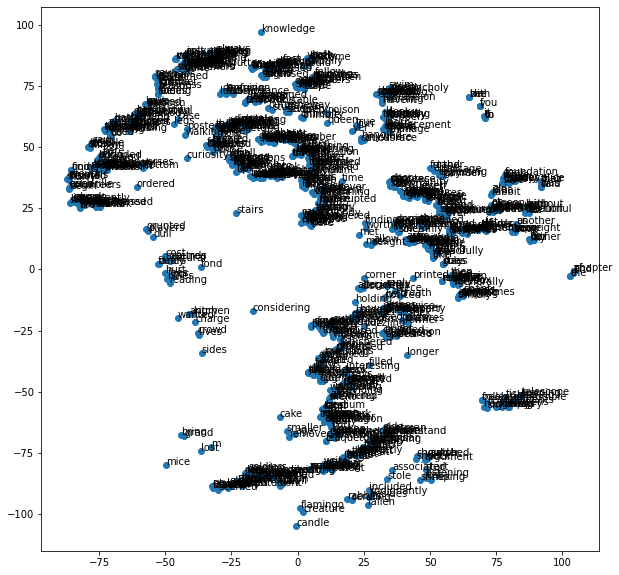

In [ ]:
num_to_show = 1000

plt.figure(figsize=(10, 10))
plt.scatter(transformed[:num_to_show, 0], transformed[:num_to_show, 1])

for i, txt in enumerate(model.wv.index2word[:num_to_show]):
  plt.annotate(txt, (transformed[i, 0], transformed[i, 1]))

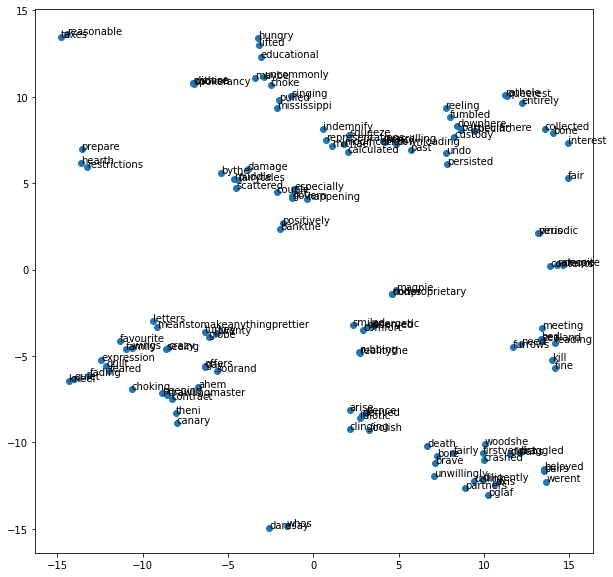

In [ ]:
plt.figure(figsize=(10, 10))

filtered_idx = np.where((np.abs(transformed[:,0]) < 15) & (np.abs(transformed[:,1]) < 15))[0]

plt.scatter(transformed[filtered_idx, 0], transformed[filtered_idx, 1])

for idx in filtered_idx:
  plt.annotate(model.wv.index2word[idx], (transformed[idx, 0], transformed[idx, 1]))